<a href="https://colab.research.google.com/github/demirkeseny/feature_selection_in_regression/blob/main/Feature_Selection_Techniques_in_a_Regression_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explanatory Data Analysis

A machine learning model can get more powerful only when the data used to train and validate it becomes a better representative of the real world. That's why data cleaning and feature selection are key steps of any data science flow. In this notebook, there is the detailed explanation of the explanatory data analysis steps before feeding the data to a regression model. \\
Refer to this [link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt) for data dictionary!

In [ ]:
# importing necessary libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from vega_datasets import data
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# first view on our data
housing_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/housing.csv')

In [ ]:
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
housing_data.shape

(1460, 81)

In [ ]:
# checking the column types 
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Fill the missing values:

In [ ]:
# checking the number of missing data in columns that contain missing data
null_df = pd.DataFrame(housing_data.isnull().sum())
null_df[null_df[0]!=0]

,0
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [ ]:
housing_data.LotFrontage = housing_data.LotFrontage.fillna(0)
housing_data.MasVnrType = housing_data.MasVnrType.fillna('None')
housing_data.MasVnrArea = housing_data.MasVnrArea.fillna(0)
housing_data.BsmtQual = housing_data.BsmtQual.fillna('NA')
housing_data.BsmtCond = housing_data.BsmtCond.fillna('NA')
housing_data.BsmtExposure = housing_data.BsmtExposure.fillna('NA')
housing_data.Electrical = housing_data.Electrical.fillna('Mix')
housing_data.GarageType = housing_data.GarageType.fillna('NA')
housing_data.Fence = housing_data.Fence.fillna('NA')
housing_data.PoolQC = housing_data.PoolQC.fillna('NA')
housing_data.PoolQC = housing_data.PoolQC.replace('NaN','NA')
housing_data.MiscFeature = housing_data.MiscFeature.fillna('NA')
housing_data.GarageCond = housing_data.GarageCond.fillna('NA')
housing_data.GarageQual = housing_data.GarageQual.fillna('NA')
housing_data.BsmtFinType1 = housing_data.BsmtFinType1.fillna('NA')
housing_data.BsmtFinType2 = housing_data.BsmtFinType2.fillna('NA')
housing_data.FireplaceQu = housing_data.FireplaceQu.fillna('NA')
housing_data.GarageFinish = housing_data.GarageFinish.fillna('NA')
housing_data.Alley = housing_data.Alley.fillna('NA')

Now decide what to do with all of the columns. There are categorical and numerical. For categorical, create dummies. For categorical there are columns like `ExterQual` which has an order like Excellent, Good, .. but they are represented with strings rather than numbers. Convert them to numbers:

In [ ]:
# converting every ordinal categorical value to numeric representations.
# since there are no nulls we can end the if loop with 1. 
housing_data.ExterQual.map(lambda x: 4 if x=="Ex" else (3 if x == 'Gd' else (2 if x == 'TA' else 1))).value_counts()

2    906
3    488
4     52
1     14
Name: ExterQual, dtype: int64

In [ ]:
# since above numbers are right, it means that we did the map function right. Let's make it inplace. 
housing_data.ExterQual = housing_data.ExterQual.map(lambda x: 4 if x=="Ex" else (3 if x == 'Gd' else (2 if x == 'TA' else 1)))

In [ ]:
housing_data.ExterCond = housing_data.ExterCond.map(lambda x: 5 if x=="Ex" else (4 if x == 'Gd' else (3 if x == 'TA' else (2 if x == 'Fa' else 1))))

In [ ]:
bsmt_zip = {'Ex':6,
            'Gd':5,
            'TA':4,
            'Fa':3,
            'Po':2,
            'NA':1}

In [ ]:
# do similar for the BsmtCond, BsmtExposure column
housing_data.BsmtQual = housing_data.BsmtQual.map(bsmt_zip)
housing_data.BsmtCond = housing_data.BsmtCond.map(bsmt_zip)

In [ ]:
bsmt_zip2 = {'Gd':5,
            'Av':4,
            'Mn':3,
            'No':2,
            'NA':1}

In [ ]:
housing_data.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
NA     38
Name: BsmtExposure, dtype: int64

In [ ]:
# do similar for the BsmtCond, BsmtExposure column
housing_data.BsmtExposure = housing_data.BsmtExposure.map(bsmt_zip2)

In [ ]:
kitchen_zip = {'Ex':5,
            'Gd':4,
            'TA':3,
            'Fa':2,
            'Po':1}
housing_data.KitchenQual = housing_data.KitchenQual.map(kitchen_zip)

In [ ]:
pool_zip = {'Ex':5,
            'Gd':4,
            'TA':3,
            'Fa':2,
            'NA':1}
housing_data.PoolQC = housing_data.PoolQC.map(pool_zip)

For the year data, I will convert it to three bins: new mid and old. Houses earlier than 1978 will be labeled as old. 1978 is picked because that is the year where it was decided that lead in wall paintings are prohibited. Since I have experienced the price change of buildings built earlier than 1978 I decided 1978 to be the threshold value. 

In [ ]:
housing_data.YearBuilt = housing_data.YearBuilt.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [ ]:
housing_data.YrSold = housing_data.YrSold.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [ ]:
housing_data.YearRemodAdd = housing_data.YearRemodAdd.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [ ]:
housing_data.drop(columns=['Id'], inplace=True)

In [ ]:
housing_data.MSSubClass = housing_data.MSSubClass.astype(str)

In [ ]:
bsmt_fin_zip = {'GLQ':6,
                'ALQ':5,
                'BLQ':4,
                'Rec':3,
                'LwQ':2,
                'Unf':1,
                'NA':0}
housing_data.BsmtFinType1 = housing_data.BsmtFinType1.map(bsmt_fin_zip)

In [ ]:
housing_data.BsmtFinType2 = housing_data.BsmtFinType2.map(bsmt_fin_zip)

In [ ]:
housing_data.HeatingQC = housing_data.HeatingQC.map(kitchen_zip)

In [ ]:
function_zip = {'Typ':7,
                'Min1':6,
                'Min2':5,
                'Mod':4,
                'Maj1':3,
                'Maj2':2,
                'Sev':1,
                'Sal':0}
housing_data.Functional = housing_data.Functional.map(function_zip)

In [ ]:
housing_data.GarageYrBlt = housing_data.GarageYrBlt.map(lambda x: 'new' if x>1999 else ('mid' if x>1978 else 'old'))

In [ ]:
garage_fin_zip = {'Fin':3,
                'RFn':2,
                'Unf':1,
                'NA':0}
housing_data.GarageFinish = housing_data.GarageFinish.map(garage_fin_zip)

In [ ]:
housing_data.GarageQual = housing_data.GarageQual.map(bsmt_zip)
housing_data.GarageCond = housing_data.GarageCond.map(bsmt_zip)

In [ ]:
pave_zip = {'Y':3,
                'P':2,
                'N':1}
housing_data.PavedDrive = housing_data.PavedDrive.map(pave_zip)

In [ ]:
fence_zip = {'GdPrv':4,
                'MnPrv':3,
                'GdWo':2,
                'MnWw':1,
                'NA':0}
housing_data.Fence = housing_data.Fence.map(fence_zip)

In [ ]:
alley_zip = {'Pave':2,
             'Grvl':1,
             'NA':0}
housing_data.Alley = housing_data.Alley.map(alley_zip)

In [ ]:
housing_data.FireplaceQu = housing_data.FireplaceQu.map(bsmt_zip)

In [ ]:
pave_zip = {'Pave':2,
             'Grvl':1}
housing_data.Street = housing_data.Street.map(pave_zip)

In [ ]:
slope_zip = {'Gtl':2,
             'Mod':1,
             'Sev':0}
housing_data.LandSlope = housing_data.LandSlope.map(slope_zip)

In [ ]:
housing_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,2,0,Reg,Lvl,AllPub,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,new,new,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,3,PConc,5,4,2,6,706,1,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,1,Attchd,new,2,2,548,4,4,3,0,61,0,0,0,0,1,0,NA,0,2,new,WD,Normal,208500
1,20,RL,80.0,9600,2,0,Reg,Lvl,AllPub,FR2,2,Veenker,Feedr,Norm,1Fam,1Story,6,8,old,old,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,3,CBlock,5,4,5,5,978,1,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,4,Attchd,old,2,2,460,4,4,3,298,0,0,0,0,0,1,0,NA,0,5,new,WD,Normal,181500
2,60,RL,68.0,11250,2,0,IR1,Lvl,AllPub,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,new,new,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,3,PConc,5,4,3,6,486,1,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,4,Attchd,new,2,2,608,4,4,3,0,42,0,0,0,0,1,0,NA,0,9,new,WD,Normal,223500
3,70,RL,60.0,9550,2,0,IR1,Lvl,AllPub,Corner,2,Crawfor,Norm,Norm,1Fam,2Story,7,5,old,old,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,3,BrkTil,4,5,2,5,216,1,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,5,Detchd,mid,1,3,642,4,4,3,0,35,272,0,0,0,1,0,NA,0,2,new,WD,Abnorml,140000
4,60,RL,84.0,14260,2,0,IR1,Lvl,AllPub,FR2,2,NoRidge,Norm,Norm,1Fam,2Story,8,5,new,new,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,3,PConc,5,4,4,6,655,1,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,7,1,4,Attchd,new,2,3,836,4,4,3,192,84,0,0,0,0,1,0,NA,0,12,new,WD,Normal,250000


All the ordinal categorical values are replaced with numerical representations. Our data doesn't have ordinal categorical values anymore. There are also no missing data. \\
The next step is to get rid of all the columns that have the object type. They need to be replaced with dummy columns so that we can feed only numeric data to our model. 

In [ ]:
df_types = pd.DataFrame(housing_data.dtypes).reset_index()
string_columns = df_types[df_types[0]=='object']['index']
non_string_columns = df_types[df_types[0]!='object']['index']

In [ ]:
# all the non-string columns
housing_data[non_string_columns].head()

,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,SalePrice
0,65.0,8450,2,0,2,7,5,196.0,3,3,5,4,2,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,1,2,2,548,4,4,3,0,61,0,0,0,0,1,0,0,2,208500
1,80.0,9600,2,0,2,6,8,0.0,2,3,5,4,5,5,978,1,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,4,2,2,460,4,4,3,298,0,0,0,0,0,1,0,0,5,181500
2,68.0,11250,2,0,2,7,5,162.0,3,3,5,4,3,6,486,1,0,434,920,5,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,4,2,2,608,4,4,3,0,42,0,0,0,0,1,0,0,9,223500
3,60.0,9550,2,0,2,7,5,0.0,2,3,4,5,2,5,216,1,0,540,756,4,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,5,1,3,642,4,4,3,0,35,272,0,0,0,1,0,0,2,140000
4,84.0,14260,2,0,2,8,5,350.0,3,3,5,4,4,6,655,1,0,490,1145,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,7,1,4,2,3,836,4,4,3,192,84,0,0,0,0,1,0,0,12,250000


In [ ]:
dummy_df = pd.get_dummies(housing_data[string_columns])

In [ ]:
# creating the ultimate dataframe where we have no categorical values
df = pd.concat([dummy_df,housing_data[non_string_columns]], axis=1)

In [ ]:
# no object typed columns left
df.dtypes.value_counts()

uint8      195
int64       50
float64      2
dtype: int64

In [ ]:
df.shape

(1460, 247)

In [ ]:
# number of missing data
df.isnull().sum().sum()

0

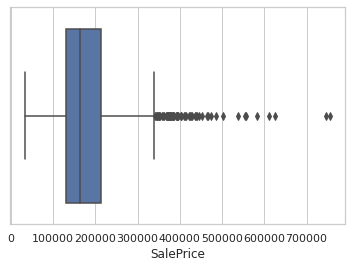

In [ ]:
# check the outliers in target value
sns.set_theme(style="whitegrid")
sns.boxplot(x=df['SalePrice']);

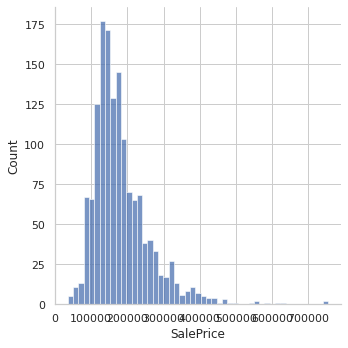

In [ ]:
sns.displot(df['SalePrice']);

In the above two charts, we see that SalePrice: \\

*   Has multiple outliers
*   Has a positive skewness \\

At this point, I decide not to tackle the outliers. I will leave them as they are. They might be handy if we see a similar data point in my testing dataset. 



# Preprocessing

In [ ]:
df.shape

(1460, 247)

In [ ]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
df_train = X_train.copy()
df_train['SalePrice']=y_train

## filter methods -  with correlation plot

No way we can add 246 features to the correlation plot of seaborn. Here we need to add the ones that are highly correlated to the target variable. 

In [ ]:
# find the most correlated columns:
df_corr = abs(df_train.corr()).sort_values(by='SalePrice', ascending=False)[['SalePrice']]
df_corr[df_corr['SalePrice']>0.4]

,SalePrice
SalePrice,1.000000
OverallQual,0.785016
GrLivArea,0.692972
ExterQual,0.667049
KitchenQual,0.658046
GarageCars,0.643580
GarageArea,0.621928
TotalBsmtSF,0.593732
BsmtQual,0.589178
1stFlrSF,0.583574


In [ ]:
df_small = df_train[df_corr[df_corr['SalePrice']>0.4].index.tolist()]
df_small.shape

(1095, 23)

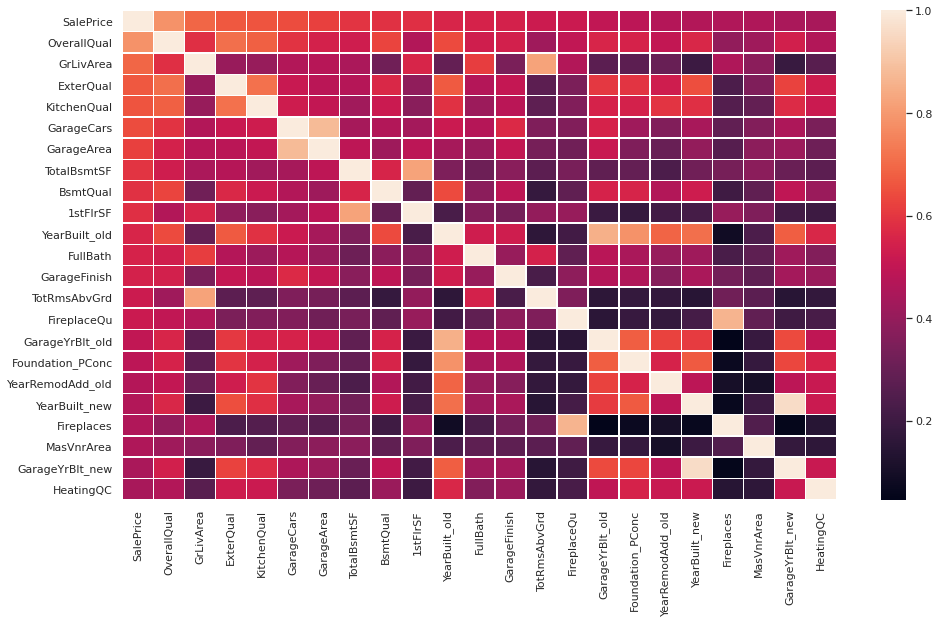

In [ ]:
plt.figure(figsize=(16,9))
ax = sns.heatmap(abs(df_small.corr()), linewidths=0.5)

Looking at the above chart, I can see that the target variable is correlated with most of the fields but the problem is collinearity which is violating one of the main assumptions of multi linear regression which is independence of predictors. Let's eliminate some that are causing colinearity.

In [ ]:
def colinear_detector(df, target_col):
  """
  aim: detect any colinearity
  inputs: all the columns
  output: colinear pairs
  """
  df_x = df.drop(columns=target_col)
  colinear_dict = {}
  for column in  df_x.columns.tolist():
    df_corre = abs(df_x.corr()).sort_values(by=column, ascending=False)[[column]]
    colinear_cols = df_corre[df_corre[column]>0.8].index.tolist()[1:]
    colinear_dict[column]= colinear_cols
  return colinear_dict
    


In [ ]:
colinear_detector(abs(df_small.corr()),'SalePrice')

{'1stFlrSF': ['TotalBsmtSF'],
 'BsmtQual': [],
 'ExterQual': ['KitchenQual'],
 'FireplaceQu': ['Fireplaces'],
 'Fireplaces': ['FireplaceQu'],
 'Foundation_PConc': ['YearBuilt_old',
  'GarageYrBlt_old',
  'YearBuilt_new',
  'GarageYrBlt_new'],
 'FullBath': [],
 'GarageArea': ['GarageCars'],
 'GarageCars': ['GarageArea'],
 'GarageFinish': [],
 'GarageYrBlt_new': ['YearBuilt_new',
  'YearBuilt_old',
  'Foundation_PConc',
  'GarageYrBlt_old'],
 'GarageYrBlt_old': ['YearBuilt_old',
  'Foundation_PConc',
  'GarageYrBlt_new',
  'YearRemodAdd_old',
  'YearBuilt_new'],
 'GrLivArea': ['TotRmsAbvGrd'],
 'HeatingQC': [],
 'KitchenQual': ['ExterQual'],
 'MasVnrArea': [],
 'OverallQual': [],
 'TotRmsAbvGrd': ['GrLivArea'],
 'TotalBsmtSF': ['1stFlrSF'],
 'YearBuilt_new': ['GarageYrBlt_new',
  'Foundation_PConc',
  'YearBuilt_old',
  'GarageYrBlt_old'],
 'YearBuilt_old': ['GarageYrBlt_old',
  'Foundation_PConc',
  'YearBuilt_new',
  'YearRemodAdd_old',
  'GarageYrBlt_new'],
 'YearRemodAdd_old': ['Year

Let's remove some of the columns based on above data. 

In [ ]:
df_small.drop(columns=['1stFlrSF','KitchenQual','FireplaceQu','Foundation_PConc','GarageCars','GarageYrBlt_new','GarageYrBlt_old','TotRmsAbvGrd'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_manual = df_small.copy()
df_manual = df_manual.drop(columns=['SalePrice'])

## filter method - Univariate Feature Selection

In [ ]:
from sklearn.feature_selection import f_regression

In [ ]:
f_val, p_val = f_regression(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [ ]:
f_val[np.isnan(f_val)]=0
p_val[np.isnan(p_val)]=0

In [ ]:
feature_dict={'columns':X_train.columns.tolist(),
              'f_scores':f_val.tolist()}

In [ ]:
feature_df = pd.DataFrame(feature_dict).sort_values(by='f_scores', ascending=False).reset_index(drop=True)

In [ ]:
feature_df.iloc[:25,:]['columns'].tolist()

['OverallQual',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 'BsmtQual',
 '1stFlrSF',
 'YearBuilt_old',
 'FullBath',
 'GarageFinish',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'GarageYrBlt_old',
 'Foundation_PConc',
 'YearRemodAdd_old',
 'YearBuilt_new',
 'Fireplaces',
 'MasVnrArea',
 'GarageYrBlt_new',
 'HeatingQC',
 'Neighborhood_NridgHt',
 'MSSubClass_60',
 'YearRemodAdd_new']

Above are the 25 columns that are picked by the univariate feature selection. I will store them so that they can be fed to the model later on. 

In [ ]:
univariate_col = feature_df.iloc[:25,:]['columns'].tolist()

In [ ]:
df_univ = X_train[univariate_col]

## filter methods - Variance Thresholding

Only predictors are included to this analysis. Here, the variance within each predictor is observed. If the variance is below certain threshold, then the predictor is removed from the analysis. The default is 0 meaning if a predictor is taking only one variable, then that predictor is removed.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

var_selector=VarianceThreshold(threshold=0.25)
df_var = var_selector.fit_transform(X_train)

In [ ]:
X.shape

(1460, 246)

In [ ]:
df_var.shape

(1095, 42)

In [ ]:
df_var

array([[4.300e+01, 3.182e+03, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        5.000e+00],
       [7.800e+01, 1.014e+04, 6.000e+00, ..., 4.000e+00, 0.000e+00,
        1.000e+00],
       [6.000e+01, 9.060e+03, 6.000e+00, ..., 3.000e+00, 0.000e+00,
        1.000e+01],
       ...,
       [6.000e+01, 8.172e+03, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        4.000e+00],
       [5.500e+01, 7.642e+03, 7.000e+00, ..., 4.000e+00, 0.000e+00,
        6.000e+00],
       [5.300e+01, 3.684e+03, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        6.000e+00]])

## wrapper method - recursive feature elimination

I will utilize RFECV function, which will apply not only recursive feature elimination but also cross validation to understand the most optimal number of features to use.

In [ ]:
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

In [ ]:
model = linear_model.LinearRegression()

In [ ]:
rfe = RFECV(estimator=model, step=5, cv=3) # if more than one, in each step there will be that many feature eliminations.

In [ ]:
rfe_fit = rfe.fit(X_train,y_train)

In [ ]:
rfe_fit.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False, False,

In [ ]:
rfe_fit.ranking_

array([39, 38, 38, 34, 35, 34, 34, 35, 35, 35, 36, 36, 34, 35, 32, 30, 30,
       29, 30, 30, 23, 24, 23, 23, 17, 17, 17, 17, 16, 16, 15, 15, 15, 15,
       15, 18, 18, 19, 20, 19, 19, 19, 22, 20, 21, 21, 20, 21, 18, 20, 17,
       16, 21, 21, 20, 19, 18, 16, 18, 16, 14, 13, 14, 14, 14, 13, 13, 14,
       13, 26, 26, 26, 32, 26, 38, 26, 38, 12, 12, 11, 12, 12, 10, 10,  9,
        9,  9, 10,  9, 10, 22, 22, 22, 25, 25, 25, 33, 33, 33, 33, 33, 34,
       37, 37, 38, 37, 36, 37, 37, 36,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  1,  7,  5,  6,  5, 36,  5,  6,  4,  5,  4,  7,
        6,  7,  5,  6,  6, 29, 29, 29, 29,  4,  1,  1,  4,  2,  4,  8,  7,
        7,  8,  8,  8, 13, 12, 28, 28, 28, 28, 28, 11,  9, 10,  8, 11, 11,
       11, 23, 23, 22, 27, 27, 27, 27, 27, 40, 31, 32, 32, 31, 31, 30, 31,
       32, 31, 25, 24, 24, 25, 24, 24, 45, 47, 41, 43, 39, 39, 41, 46, 41,
       45, 40, 40, 42, 46,  3, 44,  3,  3,  3, 45,  3,  2,  2,  2, 43, 44,
       42, 42, 42, 39, 40

In [ ]:
np.unique(rfe_fit.ranking_, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([16,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5]))

In [ ]:
rfe_dict = dict(zip(np.array(X_train.columns),rfe_fit.ranking_))

In [ ]:
selected = {}
for key, value in rfe_dict.items():
  if value==1:
    selected[key]=value
print(list(selected.keys()))

['Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_WdShing', 'Foundation_CBlock', 'Foundation_PConc']


In [ ]:
rfe_dict={'columns':X_train.columns.tolist(),
          'rfe':rfe_fit.ranking_.tolist()}

In [ ]:
rfe_df = pd.DataFrame(rfe_dict).sort_values(by='rfe', ascending=True).reset_index(drop=True)

In [ ]:
rfe_df[rfe_df['rfe']==1]['columns'].tolist()

['Exterior1st_VinylSd',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_ImStucc',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stone',
 'Exterior1st_AsbShng',
 'Exterior1st_Stucco',
 'Exterior1st_WdShing',
 'Foundation_CBlock',
 'Foundation_PConc']

In [ ]:
df_rfe = X_train[rfe_df[rfe_df['rfe']==1]['columns'].tolist()]

## embedded method - Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
pipeline = Pipeline([('sc',StandardScaler()),('model',Lasso())])

In [ ]:
lassocv = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.2)},
                      cv = 5, scoring="neg_root_mean_squared_error"
                      )

In [ ]:
lassocv.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26178213270.66696, tolerance: 497311562.877308
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28236641780.626495, tolerance: 558649426.0559995
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15328771432.843964, tolerance: 503373949.31393147
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4815383713

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprecated...None,
             param_grid={'

In [ ]:
coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lassocv.best_estimator_.named_steps['model'].coef_,
                            'abs_coef':np.abs(lassocv.best_estimator_.named_steps['model'].coef_)})

coefs.sort_values('abs_coef', inplace=True, ascending=False)

coefs.head(20)



,variable,coef,abs_coef
102,RoofMatl_ClyTile,-20278.625917,20278.625917
216,2ndFlrSF,15963.835167,15963.835167
200,OverallQual,11364.786975,11364.786975
213,TotalBsmtSF,10496.523916,10496.523916
84,HouseStyle_1Story,10150.259601,10150.259601
73,Condition2_PosN,-9265.116188,9265.116188
218,GrLivArea,8956.471711,8956.471711
209,BsmtFinSF1,8871.246551,8871.246551
51,Neighborhood_NridgHt,8582.311788,8582.311788
215,1stFlrSF,7336.239130,7336.239130


In [ ]:
print('{} features are eliminated!'.format(coefs[coefs['abs_coef']==0].shape[0]))

35 features are eliminated!


In [ ]:
df_lasso = X_train[coefs[coefs['abs_coef']==0]['variable'].tolist()]

## Finalizing Processing

In [ ]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [ ]:
X_test['GrLivArea'] = np.log(X_test['GrLivArea'])
X_test['GarageArea'] = X_test['GarageArea'].map(lambda x: 1 if x==0 else x)
X_test['GarageArea'] = np.log(X_test['GarageArea'])
X_test['TotalBsmtSF'] = X_test['TotalBsmtSF'].map(lambda x: 1 if x==0 else x);
X_test['TotalBsmtSF'] = np.log(X_test['TotalBsmtSF'])
X_test['1stFlrSF'] = np.log(X_test['1stFlrSF'])
X_test['MasVnrArea'] = X_test['MasVnrArea'].map(lambda x: 1 if x==0 else x);
X_test['MasVnrArea'] = np.log(X_test['MasVnrArea'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
def transformer(df):

  # GrLivArea will be transformed
  df['GrLivArea'] = np.log(df['GrLivArea'])

  df['GarageArea'] = df['GarageArea'].map(lambda x: 1 if x==0 else x);

  # GarageArea will be transformed
  df['GarageArea'] = np.log(df['GarageArea'])

  df['TotalBsmtSF'] = df['TotalBsmtSF'].map(lambda x: 1 if x==0 else x);

  # TotalBsmtSF will be transformed
  df['TotalBsmtSF'] = np.log(df['TotalBsmtSF'])

  # GrLivArea will be transformed
  df['1stFlrSF'] = np.log(df['1stFlrSF'])

  # MasVnrArea will be transformed
  df['MasVnrArea'] = df['MasVnrArea'].map(lambda x: 1 if x==0 else x);
  df['MasVnrArea'] = np.log(df['MasVnrArea'])



In [ ]:
for dat in [df_manual,df_univ,df_var, df_rfe, df_lasso]:
  try:
    dat = transformer(dat)
  except:
    pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Now we can start with standardizing the data. This is helpful to bring all the data to the same scale.

In [ ]:
from sklearn.preprocessing import StandardScaler
# Instantiate Standard Scaler.
ss = StandardScaler()

In [ ]:
# fit 
Z_manual = ss.fit_transform(df_manual)
Z_manual = pd.DataFrame(ss.transform(df_manual), columns=df_manual.columns)
Z_univ = ss.fit_transform(df_univ)
Z_univ = pd.DataFrame(ss.transform(df_univ), columns=df_univ.columns)
Z_var = ss.fit_transform(df_var)
Z_var = pd.DataFrame(ss.transform(df_var))
Z_rfe = ss.fit_transform(df_rfe)
Z_rfe = pd.DataFrame(ss.transform(df_rfe), columns=df_rfe.columns)
Z_lasso = ss.fit_transform(df_lasso)
Z_lasso = pd.DataFrame(ss.transform(df_lasso), columns=df_lasso.columns)

In [ ]:
Z_test = ss.fit_transform(X_test)
Z_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

# Modeling

Since our data is ready, we can start with the modelling phase.

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score

In [ ]:
linear = linear_model.LinearRegression()

In [ ]:
# manual
model = linear.fit(Z_manual, y_train)
tr_manual = model.predict(Z_manual)
te_manual = model.predict(Z_test[Z_manual.columns.tolist()])
tr_manual_sc = r2_score(tr_manual,y_train)
te_manual_sc = r2_score(te_manual,y_test)

In [ ]:
# univ
model = linear.fit(Z_univ, y_train)
tr_univ = model.predict(Z_univ)
te_univ = model.predict(Z_test[Z_univ.columns.tolist()])
tr_univ_sc = r2_score(tr_univ,y_train)
te_univ_sc = r2_score(te_univ,y_test)

In [ ]:
tr_univ_sc

0.8139110083722672

In [ ]:
te_univ_sc

0.8124922277299935

In [ ]:
def adjusted_r(r_score,rows,columns):
  adj = 1-(1-r_score**2)*(rows-1)/(rows-1-columns)
  return adj

In [ ]:
adjusted_r(tr_univ_sc,Z_univ.shape[0],Z_univ.shape[1])

0.654557096096557

In [ ]:
adjusted_r(te_univ_sc,Z_univ.shape[0],Z_univ.shape[1])

0.6521956224631267